In [ ]:
from dask.distributed import Client

In [ ]:
#$ dask-scheduler

#$ dask-worker 127.0.0.1:8786
#$ dask-worker 127.0.0.1:8786
#$ dask-worker 127.0.0.1:8786


client = Client() # '127.0.0.1:8786'
client

In [ ]:
from dask import dataframe as dd

In [1]:
import pandas
import glob

In [2]:
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# HalfHourly

### Get Data

In [5]:
fpath_glob = '../data/cleaned/halfhourly_dataset/block_*.csv'
# fpath_glob = '../data/cleaned/halfhourly_dataset/block_0.csv'

# Schema     
schema = {
    'LCLid': 'category',
    'energy(kWh/hh)': 'float64',
}

date_cols = ['tstp']

In [7]:
# # Read in Dask
# usage_data = dd.read_csv(fpath_glob, dtype=schema, parse_dates=date_cols)

# Read in Pandas
file_list = glob.glob(fpath_glob)

frames = []
for filename in file_list:
    df = pandas.read_csv(filename, dtype=schema, parse_dates=date_cols)
    frames.append(df)

usage_data = pandas.concat(frames, axis=0, ignore_index=True)

# Setup
usage_data.set_index('tstp')
usage_data.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000517,2012-03-27 11:30:00,0.305
1,MAC000517,2012-03-27 12:00:00,0.118
2,MAC000517,2012-03-27 12:30:00,0.214
3,MAC000517,2012-03-27 13:00:00,0.097
4,MAC000517,2012-03-27 13:30:00,0.117


In [ ]:
if not usage_data[id_key].cat.known:  # Compute the MACs
    usage_data[id_key] = usage_data[id_key].cat.as_known()
    
usage_data[id_key].cat.categories

### Save to Parquet

In [ ]:
test_out = '../data/parquet/halfhourly_dataset'
usage_data.to_parquet(test_out, engine='pyarrow')



### Smoke test Dask

In [ ]:
usage_data.describe().compute()

### Split MACIDs

In [ ]:
# usage_data['LCLid'] = usage_data['LCLid'].astype('category')

In [10]:
usage_data[usage_data['LCLid'] == 'MAC000002'].describe()  # .compute()

,energy(kWh/hh)
count,24140.000000
mean,0.252513
std,0.247084
min,0.000000
25%,0.112000
50%,0.158000
75%,0.286000
max,2.994000


In [11]:
usage_data[usage_data['LCLid'] == 'MAC000246'].describe()  # .compute()

,energy(kWh/hh)
count,39244.000000
mean,0.350956
std,0.437538
min,0.014000
25%,0.070000
50%,0.138000
75%,0.487000
max,3.516000


In [12]:
usage_data['energy(kWh/hh)'].mean()  # .compute()

0.27142602431598295

In [13]:
usage_means = usage_data.groupby('LCLid')['energy(kWh/hh)'].mean()  # .compute()

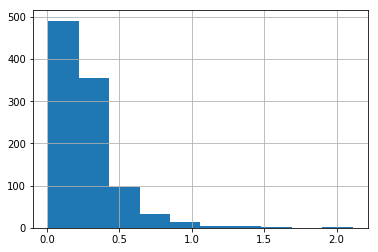

In [14]:
usage_means.hist()

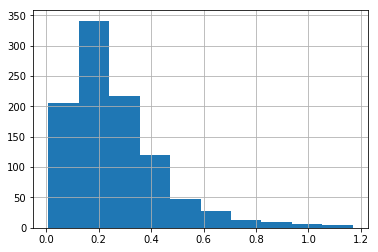

In [15]:
usage_means[usage_means < 1.2].hist()

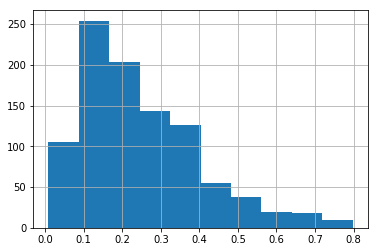

In [16]:
usage_means[usage_means < 0.8].hist()

^ looks about like a right-skew hist

In [ ]:
test_ids = ['MAC000246', 'MAC000002']

In [18]:
# usage_data[usage_data[id_key] in test_ids].describe().compute()
individual_usage = usage_data[usage_data['LCLid'] == 'MAC000246']  # .compute()

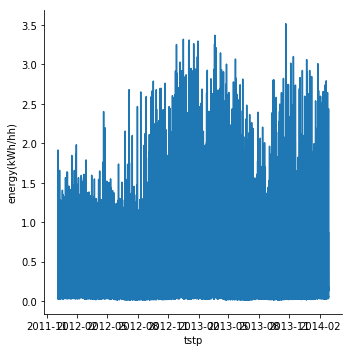

In [19]:
sns.relplot(x='tstp', #x='tmp_index',
            y='energy(kWh/hh)',
            kind="line",
            legend="full",
            data=individual_usage)



# Daily

### Get Data

In [20]:
#fpath_glob = '../data/cleaned/daily_dataset/block_*.csv'
fpath_glob = '../data/cleaned/daily_dataset/block_0.csv'

# Schema     
schema = {
    'LCLid': 'category',
    'energy_median': 'float64',
    'energy_mean': 'float64',
    'energy_max': 'float64',
    'energy_count': 'int32',
    'energy_std': 'float64',
    'energy_sum': 'float64',
    'energy_min': 'float64',
    'energy(kWh/hh)': 'float64',
    
}

date_cols = ['day']

In [21]:
# # Read in Dask
# agg_usage_data = dd.read_csv(fpath_glob, dtype=schema, parse_dates=date_cols)

# Read in Pandas
file_list = glob.glob(fpath_glob)

frames = []
for filename in file_list:
    df = pandas.read_csv(filename, dtype=schema, parse_dates=date_cols)
    frames.append(df)

agg_usage_data = pandas.concat(frames, axis=0, ignore_index=True)

# Setup
agg_usage_data.set_index('day')
agg_usage_data.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000
1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076
2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070
3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070
4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087


In [22]:
usage_means = agg_usage_data.groupby('LCLid')['energy_sum'].mean()
usage_means

LCLid
MAC000002     12.070638
MAC000246     16.816769
MAC000450     72.267393
MAC001074     23.021159
MAC003223     19.154083
MAC003239      7.568414
MAC003252     12.773310
MAC003281      9.366736
MAC003305     15.741560
MAC003348     11.732656
MAC003388     28.847566
MAC003394     27.218389
MAC003400     12.187364
MAC003422     18.465947
MAC003423     17.872087
MAC003428     26.144729
MAC003449     48.955359
MAC003463     15.492099
MAC003482     13.142364
MAC003553     17.267682
MAC003557      9.981382
MAC003566     29.049535
MAC003579     10.950002
MAC003597     28.677199
MAC003613     33.051958
MAC003646     10.648527
MAC003656     17.684838
MAC003668     36.932719
MAC003680     16.968186
MAC003686     16.228549
MAC003718      9.988258
MAC003719     13.640376
MAC003737     10.082427
MAC003740     10.288597
MAC003775     29.732668
MAC003805     12.731640
MAC003817     21.908172
MAC003826     10.594512
MAC003844     14.574300
MAC003851     13.436961
MAC003856     34.223923
MAC003863 

In [23]:
### Pick out some individuals just to see

In [24]:
test_ids = ['MAC000246', 'MAC000002']

agg_individual_usage = agg_usage_data[agg_usage_data['LCLid'] == 'MAC000246']

# agg_individual_usage.compute().head()
agg_individual_usage.head()



,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
505,MAC000246,2011-12-03,0.1150,0.300233,1.179,30,0.361231,9.007,0.047
506,MAC000246,2011-12-04,0.1750,0.432563,1.914,48,0.484152,20.763,0.026
507,MAC000246,2011-12-05,0.0780,0.125417,0.934,48,0.153327,6.020,0.025
508,MAC000246,2011-12-06,0.1140,0.277542,1.216,48,0.313399,13.322,0.027
509,MAC000246,2011-12-07,0.1035,0.188792,0.873,48,0.209613,9.062,0.026


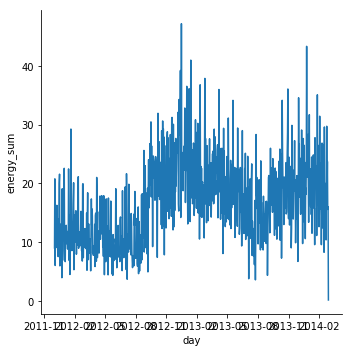

In [25]:
sns.relplot(x='day',
            y='energy_sum',
            #y='energy_median',
            #y='energy_mean',
            kind="line",
            data=agg_individual_usage)


## Sample

In [32]:
print(f"total: {len(agg_usage_data)}")
sample_frac = 0.80

# Group and split
grouped_usage = agg_usage_data.groupby('LCLid')

train_test_set = []
valid_set = []
for lcl_id, df in grouped_usage:
    cutoff_index = int(len(df) * sample_frac)  # I'm upset that I have to cast this shit

    train_test = df[:cutoff_index]
    train_test_set.append(train_test)

    valid = df[cutoff_index:]
    valid_set.append(valid)

# Recombine
#  TODO: This seems like it won't scale terribly well. Storing it might help?
agg_usage_train_test = pandas.concat(train_test_set, axis=0, ignore_index=False)
print(f"train_test: {len(agg_usage_train_test)}")

agg_usage_valid = pandas.concat(valid_set, axis=0, ignore_index=False)
print(f"valid: {len(agg_usage_valid)}")

total: 25574
train_test: 20443
valid: 5131


In [67]:
single_agg_usage = agg_usage_data[agg_usage_data['LCLid'] == 'MAC000246']
single_agg_usage.describe()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,819.000000,819.000000,819.000000,819.000000,818.000000,819.000000,819.000000
mean,0.191952,0.350693,1.643600,47.916972,0.391360,16.816769,0.034082
std,0.128718,0.145270,0.623612,1.758790,0.144419,6.992402,0.016401
min,0.045500,0.074396,0.135000,1.000000,0.019962,0.145000,0.014000
25%,0.090500,0.234833,1.179500,48.000000,0.284874,11.256000,0.023000
50%,0.151000,0.343500,1.447000,48.000000,0.365398,16.488000,0.029000
75%,0.263000,0.439437,2.072000,48.000000,0.482027,21.093000,0.040500
max,0.771000,0.982667,3.516000,48.000000,0.889821,47.168000,0.145000


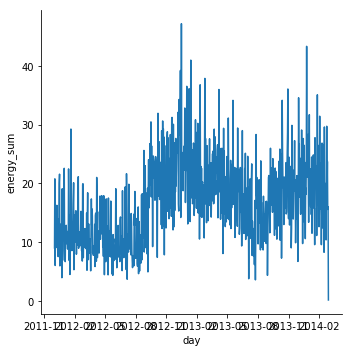

In [29]:
sns.relplot(x='day',
            y='energy_sum',
            #y='energy_median',
            #y='energy_mean',
            kind="line",
            data=single_agg_usage)


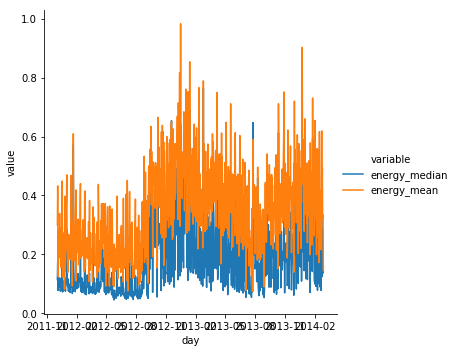

In [30]:
single_agg_melt = pandas.melt(single_agg_usage, id_vars=['LCLid', 'day'], value_vars=['energy_median', 'energy_mean'])

sns.relplot(x='day',
            y='value',
            hue='variable',
            kind="line",
            data=single_agg_melt)


^ positive outliers?

# Analysis
https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc444.htm

### Some TS specific packages

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/home/nathaniel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Hist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8afaa42da0>,
      dtype=object)

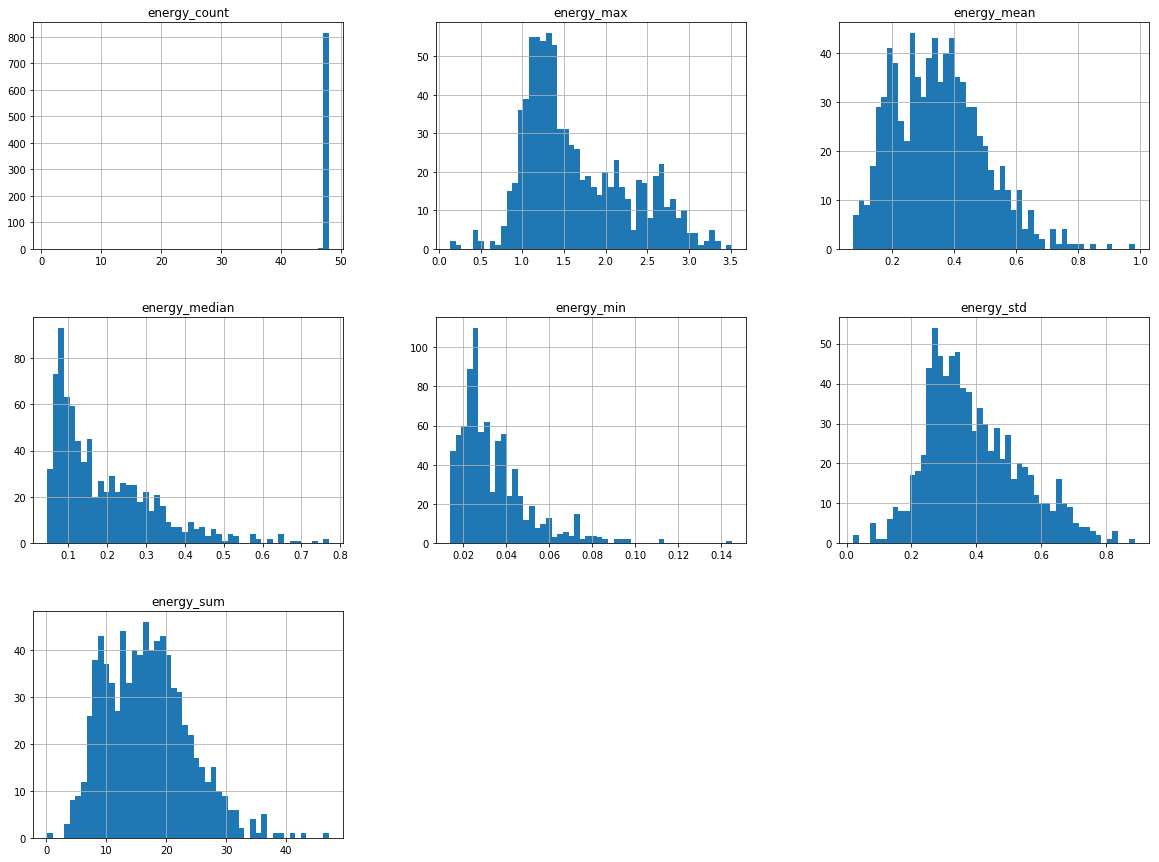

In [35]:
single_agg_usage.hist(bins=50, figsize=(20,15))

^ Again, kinda a right skew on most things

### Stationality

In [36]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(single_agg_usage['energy_sum'].values)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

print('Critical Values:')
for key, value in result[4].items():
    print(f'  {key}: {value}')
#     print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.8742275341603007
p-value: 0.34428070672283545
Critical Values:
  1%: -3.438581476199162
  5%: -2.865173218890781
  10%: -2.56870466056054


H(0): Has unit root, is non stationary

H(1): No unit root, is stationary

Accept: Series is not stationary.
    Look for a trend?
    

### Autocorrelation
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm

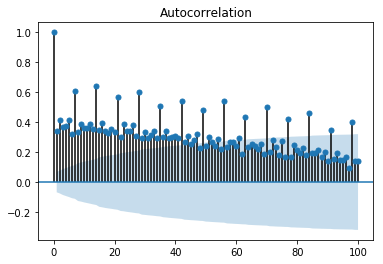

In [39]:
plot_acf(single_agg_usage['energy_sum'], lags=100, unbiased=True)
pyplot.show()  # This keeps things from showing up twice?

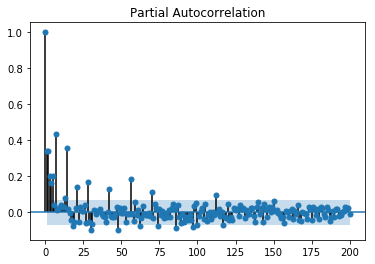

In [40]:
plot_pacf(single_agg_usage['energy_sum'], lags=200)
pyplot.show()  # This keeps things from showing up twice?

If I remember, these guys are NOT going down quickly enough to show that there ISN'T Autocorrelation, but looks a little low.

Low Partial ac, which means Auto-regressive?

Also, some periodic spikes, something to look into?

### Decompose

In [75]:
def readd_decomp(df, decomp, key):
    '''Adds decomp series back on to dataframe, with key as a prefix.'''
    df[f'{key}_resid'] = decomp.resid
    df[f'{key}_seasonal'] = decomp.seasonal
    df[f'{key}_trend'] = decomp.trend

    # return df

/home/nathaniel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


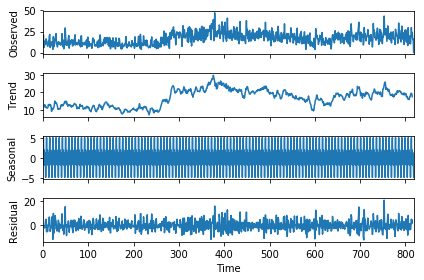

In [80]:
%matplotlib inline

decompose_key = 'energy_sum'

# TODO: Freq this
# freq = 1
freq = 7
# freq = 30
# freq = 365

single_agg_decomp = seasonal_decompose(single_agg_usage[decompose_key].values, model='additive', two_sided=True, freq=freq)
# single_agg_decomp = seasonal_decompose(single_agg_usage[decompose_key].values) #, model='additive', two_sided=True)

single_agg_decomp.plot().show()

In [81]:
readd_decomp(single_agg_usage, single_agg_decomp, decompose_key)

/home/nathaniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nathaniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/nathaniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

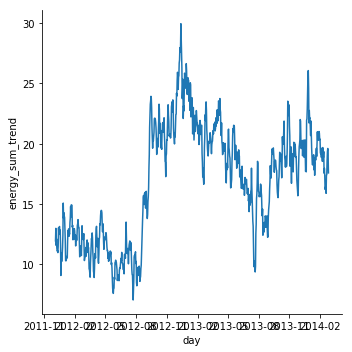

In [82]:
sns.relplot(x='day',
            y='energy_sum_trend',
            #y='energy_median',
            #y='energy_mean',
            kind="line",
            data=single_agg_usage)

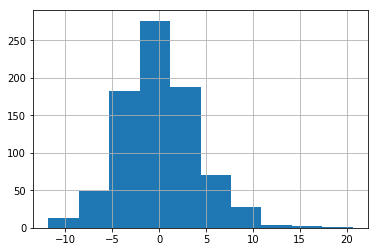

In [83]:
pandas.Series(single_agg_decomp.resid).hist()

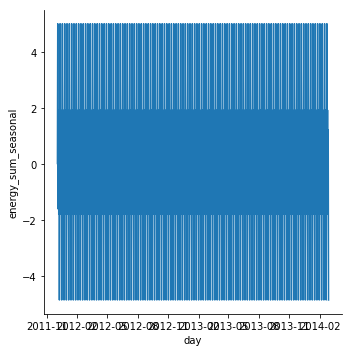

In [84]:
sns.relplot(x='day',
            y='energy_sum_seasonal',
            #y='energy_median',
            #y='energy_mean',
            kind="line",
            data=single_agg_usage)

In [41]:
result = seasonal_decompose(single_agg_usage[KEY].values, model='additive', two_sided=True, freq=144)

# Out
result.plot()
pyplot.show()

AttributeError: 'Int64Index' object has no attribute 'inferred_freq'

In [ ]:
dots = sns.load_dataset("dots")
dots.head()

In [ ]:
import pandas

In [ ]:
hhour_fname = 'block_1.csv'
hhour_fpath = f"{hhour_dir}/{hhour_fname}"

df = pandas.read_csv(hhour_fpath)
df.describe()

In [ ]:
df['energy(kWh/hh)'].mean()